In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")AA

In [4]:
device

device(type='cpu')

# 데이터 준비 

In [5]:
train_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = True,
                                                 transform = transforms.Compose([
                                                     transforms.ToTensor()
                                                 ]))
test_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = False,
                                                 transform = transforms.Compose([
                                                     transforms.ToTensor()
                                                 ]))

In [6]:
# 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = 100)

In [7]:
# 분류 클래스 정의
labels_map = {0: "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
             5: "Sandal", 6: "Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}

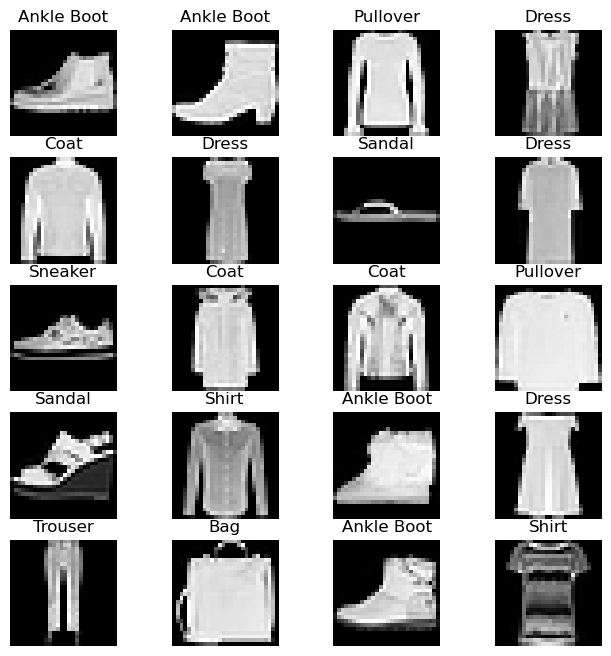

In [8]:
fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5

for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis("off")
    plt.imshow(img, cmap = "gray")
    
plt.show()

# 심층 신경망 모델 생성

In [9]:
28 * 28

784

In [10]:
class FashionDNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 28 * 28 = 784
        self.fc1 = nn.Linear(in_features = 784, out_features = 256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        # 활성화함수는 F.relu()로 forward() 함수에서 정의할 수도 있고
        # nn.ReLU() 로 __init__() 에서 정의할 수도 있음
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

- nn 과 nn.functional 의 비교
    - nn
        - 형태 : 클래스
        - 호출 방법 : 하이퍼파라미터를 전달한 후 함수 호출을 통해 데이터 전달
        - 위치 : nn.Sequential 내에 위치
            - \_\_init__() 내
    - nn.functional
        - 형태 : 함수
        - 호출 방법 : 함수를 호출할 때 하이퍼파라미터, 데이터 전달
        - 위치 : nn.Sequential 바깥
            - forward() 함수 내

In [11]:
# 심층 신경망 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


# 모델 학습

In [13]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        
        # 이 과정은 항상 고정
        outputs = model(train)
        loss = criterion(outputs, labels)   # 손실값
        optimizer.zero_grad()   # 옵티마이저 과거기록 삭제
        loss.backward()   # 손실값을 가지고 백워드(오차역전파)
        optimizer.step()   # 가중치조절
        count += 1
        
        
        # 여기부터는 훈련과정 찍는 과정(그닥 노중요)
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test) # 결과
                predictions = torch.max(outputs, 1)[1].to(device) 
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not(count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%")

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.6142536401748657, Accuracy: 83.25
Iteration: 1000, Loss: 0.4712292551994324, Accuracy: 84.27999877929688
Iteration: 1500, Loss: 0.3446035385131836, Accuracy: 84.27999877929688
Iteration: 2000, Loss: 0.35797297954559326, Accuracy: 85.33000183105469
Iteration: 2500, Loss: 0.2750117778778076, Accuracy: 86.23999786376953
Iteration: 3000, Loss: 0.3313005566596985, Accuracy: 86.0


- predictions = torch.max(outputs, 1)[1].to(device)
    - 결과가 최댓값, 인덱스 이렇게나옴
- 1epoch = 10step(iteration)

# 합성곱 신경망 모델 생성

- Conv2d 계층에서 출력 크기 구하는 공식
    - 출력 크기 = (W - F + 2P)/S + 1
        - W : 입력 데이터의 크기(input_volumn_size)
        - F : 커널 크기(kervel_size)
        - P : 패딩 크기(padding_size)
        - S : 스트라이드(strides)
        
- MaxPool2d 계층에서 출력 크기 구하는 공식
    - 출력 크기 = IF/F
        - IF : 입력 필터의 크기(input_filter_size, 바로 앞의 Conv2d 의 출력 크기)
        - F : 커널 크기

- 28 * 28
    - W : 28
    - F : 3
    - P : 1
    - S : 1
- 출력 크기 = (W - F + 2P)/S + 1
    - (28 - 3 + 2*1)/1 + 1

In [15]:
class FashionCNN(nn.Module):
    def __init__(self):
        # 데이터 크기 28 * 28
        super().__init__()
        # Sequential은 forward 함수에서 구현될 순전파를 계층 형태로 더 가독성 있게 만들어 줌
        # 즉, 계층을 차례대로 쌓을 수 있도록 Wx + b 와 같은 수식과 활성화 함수를 연결해주는 역할
        # 데이터가 각 계층을 순차적으로 지나갈 때 효과적
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            # (28 - 3 + 2 * 1)/1 + 1 = 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            # 28 / 2 = 14 (가로 세로 크기)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
            # (14 - 3 + 2 * 0)/1 + 1 = 12
            nn.BatchNorm2d(64),   # 들어오는 입력 채널이 얼마냐
            nn.ReLU(),
            nn.MaxPool2d(2)
            # 12 / 2 = 6
        )
        
        self.fc1 = nn.Linear(in_features =64 * 6 * 6, out_features = 600) 
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features = 600, out_features = 120)
        self.fc3 = nn.Linear(in_features = 120, out_features = 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # out.size(0) : 배치차원, -1 : flatten 해주는거임
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [16]:
# 합성곱 신경망 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


# 모델 학습 

In [17]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        # Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지
        # 자동 미분에 대한 값을 저장
        
        
        # 이 과정은 항상 고정
        outputs = model(train)
        loss = criterion(outputs, labels)   # 손실값
        optimizer.zero_grad()   # 옵티마이저 과거기록 삭제
        loss.backward()   # 손실값을 가지고 백워드(오차역전파)
        optimizer.step()   # 가중치조절
        count += 1
        
        
        # 여기부터는 훈련과정 찍는 과정(그닥 노중요)
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test) # 결과
                predictions = torch.max(outputs, 1)[1].to(device) 
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not(count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%")

C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.45548850297927856, Accuracy: 87.05999755859375%
Iteration: 1000, Loss: 0.31254249811172485, Accuracy: 88.01000213623047%
Iteration: 1500, Loss: 0.29879552125930786, Accuracy: 88.19000244140625%
Iteration: 2000, Loss: 0.22497761249542236, Accuracy: 89.43000030517578%
Iteration: 2500, Loss: 0.15397274494171143, Accuracy: 89.61000061035156%
Iteration: 3000, Loss: 0.17625272274017334, Accuracy: 90.20999908447266%
